In [74]:
import sys

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import s3fs
import scipy
import seaborn as sns

sys.path.append("/Users/fgu/dev/projects/entropy")
import entropy.data.aggregators as ag
import entropy.data.cleaners as cl
import entropy.data.make_data as md
import entropy.data.selectors as sl
import entropy.data.validators as vl
import entropy.helpers.aws as ha
import entropy.helpers.data as hd
import entropy.helpers.helpers as hh

pd.set_option("display.max_rows", 120)
pd.set_option("display.max_columns", 120)
pd.set_option("max_colwidth", None)
%load_ext autoreload
%autoreload 2

fs = s3fs.S3FileSystem(profile="3di")

month = pd.Grouper(key="date", freq="m")
idx_cols = ["user_id", month]

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [143]:
df = hd.read_txn_data("777")
hd.inspect(df)

Time for read_txn_data                 : 3.02 seconds
(651,789, 21)


,date,user_id,amount,desc,merchant,tag_group,tag,account_id,account_last_refreshed,account_provider,account_type,debit,female,id,is_urban,latest_balance,logins,postcode,region_name,tag_auto,yob
0,2012-02-01,777,400.00,<mdbremoved> - s/o,NaN,transfers,other_transfers,262916,2020-07-21 20:32:00,natwest bank,current,True,0.0,688300,1.0,364.220001,0.0,wa1 4,north west,transfers,1969.0
1,2012-02-01,777,3.03,aviva pa - d/d,aviva,spend,finance,262916,2020-07-21 20:32:00,natwest bank,current,True,0.0,688299,1.0,364.220001,0.0,wa1 4,north west,health insurance,1969.0


In [3]:
dfa = hd.read_analysis_data("777")
hd.inspect(dfa)

Time for read_analysis_data            : 0.40 seconds
(729, 40)


,user_id,month,date,active_accounts,txns_count,txns_value,txn_count_sa,txn_count_ca,prop_credit,month_income,year_income,has_regular_income,has_month_income,entropy,entropyz,age,female,sa_inflows,has_sa_inflows,has_reg_sa_inflows,has_benefits,has_pension,has_mortgage_pmt,has_rent_pmt,loan_funds,loan_repmt,pdloan_funds,pdloan_repmt,region_name,is_urban,spend_finance,spend_services,spend_other_spend,spend_household,spend_motor,spend_communication,spend_retail,spend_travel,spend_hobbies,month_spend
0,13777,11,2012-11-30,"[112648, 112650, 112652, 112651]",100,317126.781250,14.0,85.0,0.102756,6366.030273,69899.824219,0,1,0.827491,0.081098,43.0,0.0,50076.0,1,0,0,0,3.0,3.0,0,0,0,0,south east,0.0,1151.430054,403.660004,1686.0,6983.815918,0.000000,0.0,501.670013,136.899994,25.000000,11073.820312
1,13777,12,2012-12-31,"[112648, 112650, 112652, 112651, 112653]",65,34068.792969,8.0,52.0,0.022894,5283.939941,69899.824219,0,1,0.853535,0.389008,43.0,0.0,3250.0,1,0,0,0,3.0,1.0,0,0,0,0,south east,0.0,13.530000,141.889999,1030.0,5677.649902,202.669998,0.0,183.949997,0.000000,94.989998,7344.680176


**Smoothed calculation**

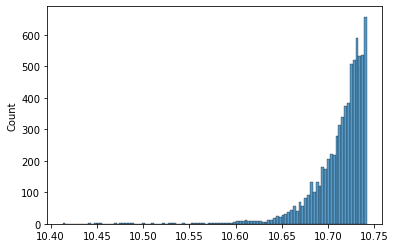

In [98]:
a = _entropy_smoothed(mw_counts)
sns.histplot(a);

## User-month-level entropy

For each category `merchant`, `tag`, and `auto_tag`, we calculate both category-based and category-time-based entropy. Could also add third timension to permutation: counts vs amount. But don't do this for now, as I'd think that they correlate strongly.

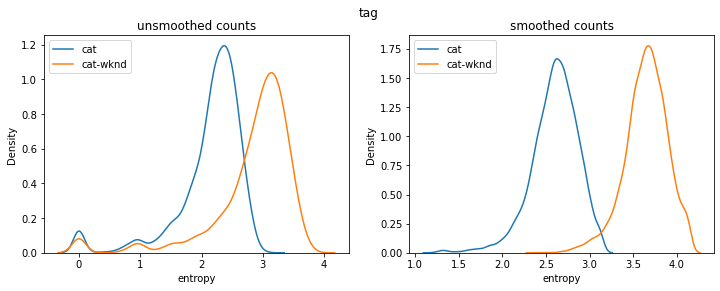

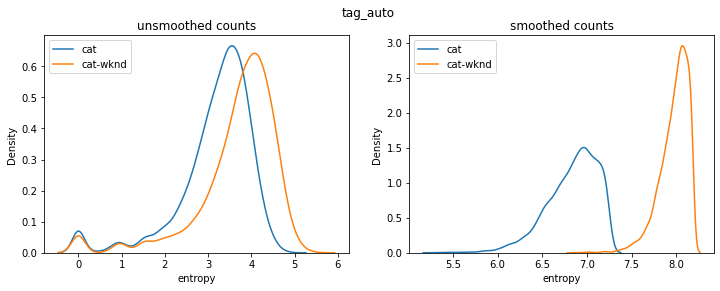

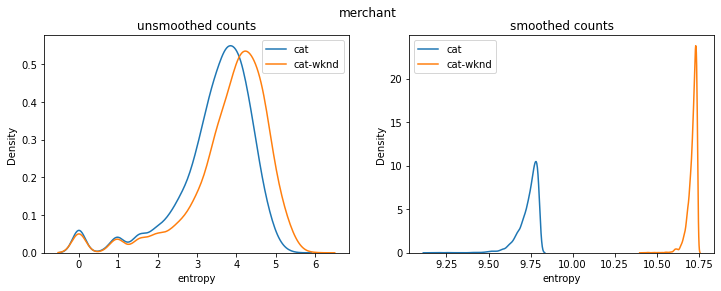

In [138]:
def counts(df, cat, wknd=False):
    """Count of txns for each category"""
    is_cat_observed_spend = df.tag_group.eq("spend") & df.debit & df[cat].notna()
    df = df.loc[is_cat_observed_spend].copy()
    if wknd:
        is_wknd = df.date.dt.dayofweek.isin([5, 6, 0]).astype(str)
        df[cat] = df[cat].astype(str) + is_wknd
    group_cols = idx_cols + [cat]
    return df.groupby(group_cols, observed=True).size().unstack().fillna(0)


def _entropy(df, smoothed=False):
    row_totals = df.sum(1)
    num_unique = len(df.columns)
    if smoothed:
        probs = (df + 1).div(row_totals + num_unique, axis=0)
    else:
        probs = (df).div(row_totals, axis=0)
    e = ss.entropy(probs, base=2, axis=1)
    return pd.Series(e, index=df.index)


cats = ["tag", "tag_auto", "merchant"]
for cat in cats:
    fig, ax = plt.subplots(1, 2, figsize=(12, 4))
    c = counts(df, cat, wknd=False).pipe(_entropy, smoothed=False)
    cw = counts(df, cat, wknd=True).pipe(_entropy, smoothed=False)
    sc = counts(df, cat, wknd=False).pipe(_entropy, smoothed=True)
    scw = counts(df, cat, wknd=True).pipe(_entropy, smoothed=True)
    sns.kdeplot(c, label="cat", ax=ax[0])
    sns.kdeplot(cw, label="cat-wknd", ax=ax[0])
    sns.kdeplot(sc, label="cat", ax=ax[1])
    sns.kdeplot(scw, label="cat-wknd", ax=ax[1])
    fig.suptitle(cat)
    ax[0].legend()
    ax[0].set(
        title="unsmoothed counts",
        xlabel="entropy",
    )
    ax[1].legend()
    ax[1].set(title="smoothed counts", xlabel="entropy")
    # print("corrs")
    # print("cat: ", c.corr(sc))
    # print("cat-wknd", cw.corr(scw))
    # plt.plot()

### Smoothing

Use of [additive smoothing](https://en.wikipedia.org/wiki/Additive_smoothing) makes huge difference to entropy distribution once we calculate entropy based on larger number of categories. Because the large majority of merchants have zero counts (and thus equal probability of `1/row_unique`, entropy values are strongly biased towards max entropy case of uniform distribution.

In [139]:
unique_merchs = len(mw_counts.columns)

scipy.stats.entropy([1 / unique_merchs] * unique_merchs, base=2)

10.742309436084

When calculating tag-based entropy with only 9 unique categories, this is a minor issue because the relative weight of zero categories is much smaller, given that spend in the median user-month is across 5 or 6 categories. So it's not a problem there. But we might want to use a way to calcualte entropy that we can use across all three measures.

Without smoothing, we don't have this problem, and we get a much more sensible distribution.

Near zero scores are user-months for which almost all (merchant, weekend) counts are zero, in which case we have the below case. This is the case because internally, `entropy()` uses [`scipy.special.entr()`](https://docs.scipy.org/doc/scipy/reference/generated/scipy.special.entr.html#scipy.special.entr), which returns `entr(0) = 0` and `entr(p) = -p * log(p) for p > 0`.

In [140]:
scipy.stats.entropy([0] * (unique_merchs - 1) + [1])

0.0

In [141]:
mw_counts.gt(0).sum(1).describe()

count    7272.000000
mean       22.156903
std        12.023792
min         1.000000
25%        14.000000
50%        21.000000
75%        30.000000
max        85.000000
dtype: float64

These near zero counts are clearly artefacts of the data. The best solution would probably be to define a sensible minimum number of spend txns with known merchant names.

In particular, we need a data-driven approach to setting this that we can replicate across all entropy measures.

Calculate tag based entropy before making decision.

### Open question

We probably don't want to smooth, but how to deal with near zero cases? Impose upper limit of cat observed spend txns?

## User-level entropy